# Regressão Linear

In [24]:
#@title 1. Importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates

In [28]:
#@title 2. Carregar os dados
df = pd.read_csv('/content/SP500.csv')
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000


In [29]:
#@title 3. Ajustando Dataset
df['Target_Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)  # Remover última linha com Target nulo

X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Target_Close']

In [30]:
#@title 4. Treino e Teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Coeficientes: [ 9.00724081e-02 -6.19550342e-02 -6.24257430e-02  1.03400662e+00
 -3.75557287e-10]
Intercepto: 2.4985346934233803
R²: 0.9991946283666845
Erro médio quadrático (MSE): 277.78246030905945
Raiz do erro médio quadrático (RMSE): 16.666807142013116


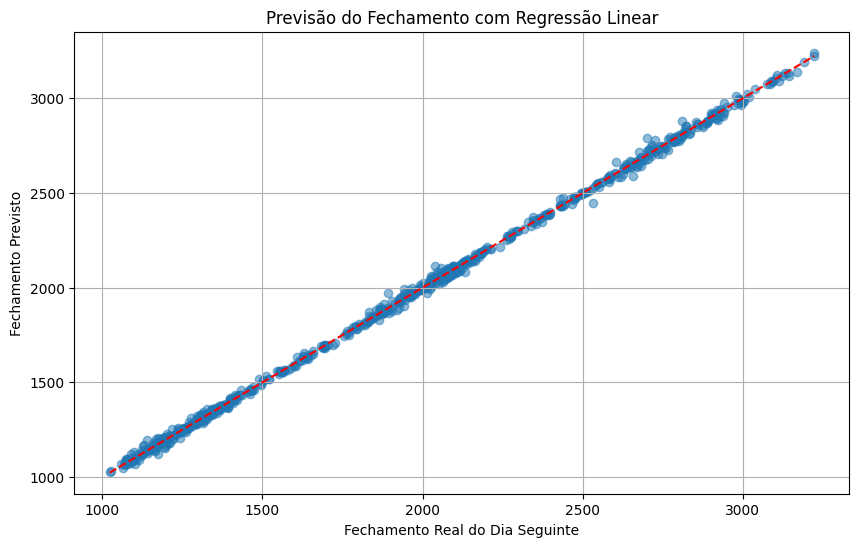

In [31]:
#@title 5. Avaliação e Visualização

y_pred = model.predict(X_test)

# Avaliação
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)
print("R²:", r2_score(y_test, y_pred))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("Raiz do erro médio quadrático (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))

# Visualização
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Fechamento Real do Dia Seguinte')
plt.ylabel('Fechamento Previsto')
plt.title('Previsão do Fechamento com Regressão Linear')
plt.grid(True)
plt.show()

In [32]:
#@title 6. Gerar sinais de compra e venda com base nas previsões do modelo

# Cria uma cópia do DataFrame original para aplicar a estratégia
df_strategy = df.copy()
# Adiciona uma nova coluna com os preços de fechamento previstos pelo modelo
df_strategy['Predicted_Next_Close'] = model.predict(X)
# Inicializa a coluna 'Signal' com 0 (nenhum sinal)
df_strategy['Signal'] = 0
# Define o sinal como 1 (compra) quando o preço previsto for maior que o preço atual
df_strategy.loc[df_strategy['Predicted_Next_Close'] > df_strategy['Close'], 'Signal'] = 1
# Define o sinal como -1 (venda) quando o preço previsto for menor que o preço atual
df_strategy.loc[df_strategy['Predicted_Next_Close'] < df_strategy['Close'], 'Signal'] = -1
# Exibe as últimas linhas com data, preço real, previsão e sinal gerado
df_strategy[['Date', 'Close', 'Predicted_Next_Close', 'Signal']].tail()

,Date,Close,Predicted_Next_Close,Signal
2510,2019-12-23,3224.010010,3224.443186,1
2511,2019-12-24,3223.379883,3224.595477,1
2512,2019-12-26,3239.909912,3240.257409,1
2513,2019-12-27,3240.020020,3241.140828,1
2514,2019-12-30,3221.290039,3222.456725,1


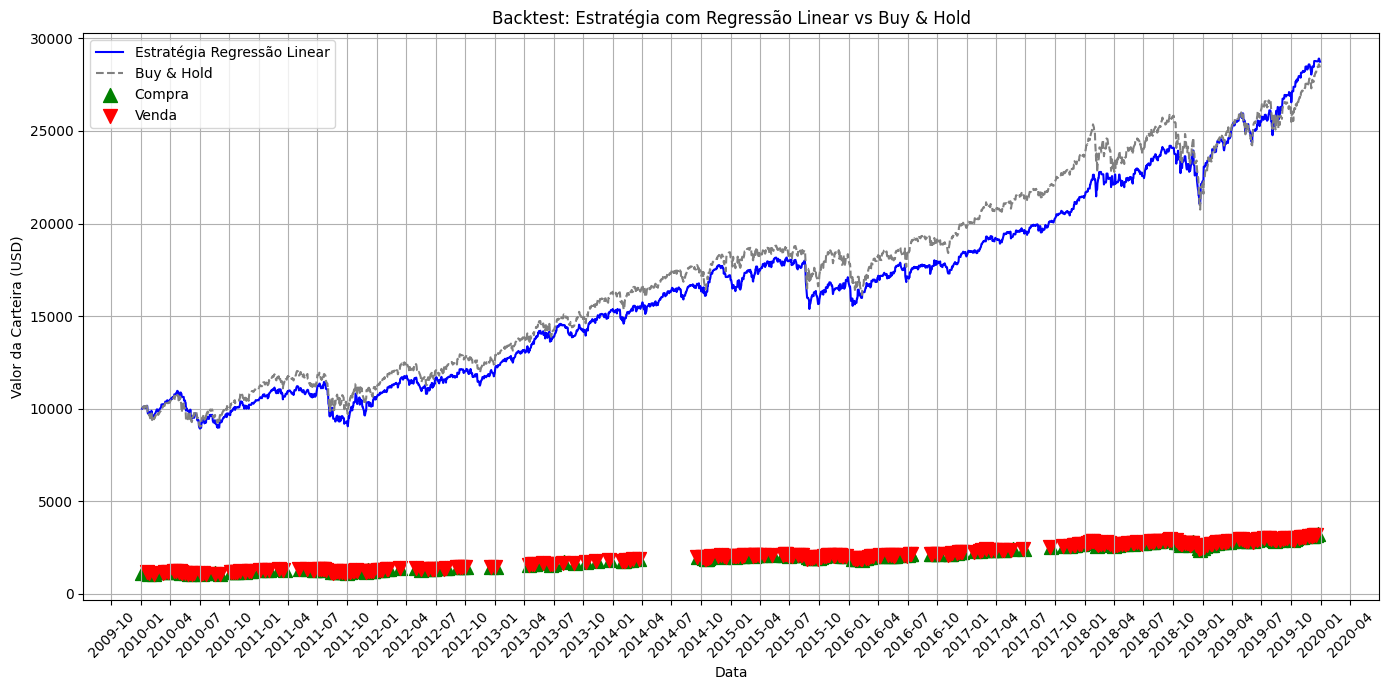

In [33]:
# Simulação de carteira
initial_cash = 10000
cash = initial_cash
shares = 0
portfolio_value = []
buy_dates = []
sell_dates = []

for i in range(len(df_strategy)):
    signal = df_strategy.loc[i, 'Signal']
    close_price = df_strategy.loc[i, 'Close']
    date = df_strategy.loc[i, 'Date']

    if signal == 1 and cash > 0:
        shares = cash / close_price
        cash = 0
        buy_dates.append((date, close_price))
    elif signal == -1 and shares > 0:
        cash = shares * close_price
        shares = 0
        sell_dates.append((date, close_price))

    total = cash + shares * close_price
    portfolio_value.append(total)

df_strategy['Portfolio_Value'] = portfolio_value

# Buy & Hold para comparação
buy_and_hold = (df_strategy['Close'] / df_strategy['Close'].iloc[0]) * initial_cash

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_strategy['Date'], df_strategy['Portfolio_Value'], label='Estratégia Regressão Linear', color='blue')
plt.plot(df_strategy['Date'], buy_and_hold, label='Buy & Hold', color='gray', linestyle='--')

# Sinais de compra e venda
for date, price in buy_dates:
    plt.scatter(date, price, color='green', marker='^', s=100, label='Compra' if buy_dates.index((date, price)) == 0 else "")
for date, price in sell_dates:
    plt.scatter(date, price, color='red', marker='v', s=100, label='Venda' if sell_dates.index((date, price)) == 0 else "")

# Formatação
plt.xlabel('Data')
plt.ylabel('Valor da Carteira (USD)')
plt.title('Backtest: Estratégia com Regressão Linear vs Buy & Hold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()